# This is a learning project. It aims to have hands on experience in NLP

### Trying to build a model that predicts which Product do the customer complaints concern
### Will work with [Customer Complaint Database](https://www.kaggle.com/datasets/selener/consumer-complaint-database) from Kaggle

BERT Input and Output BERT model expects a sequence of tokens (words) as an input. In each sequence of tokens, there are two special tokens that BERT would expect as an input:

- [CLS]: This is the first token of every sequence, which stands for classification token.
- [SEP]: This is the token that makes BERT know which token belongs to which sequence. This special token is mainly important for a next sentence prediction task or question-answering task. If we only have one sequence, then this token will be appended to the end of the sequence.

In [26]:
# imports

from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

import tensorflow as tf
import pandas as pd
import numpy as np
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
root_path = './data/customer-complaints.csv'

In [3]:
df_dump = pd.read_csv(root_path)
df_dump.head()

C:\Users\harun\AppData\Local\Temp\ipykernel_16540\1564091878.py:1: DtypeWarning:

Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.



,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,05/10/2019,Checking or savings account,Checking account,Managing an account,Problem using a debit or ATM card,NaN,NaN,NAVY FEDERAL CREDIT UNION,FL,328XX,Older American,NaN,Web,05/10/2019,In progress,Yes,NaN,3238275
1,05/10/2019,Checking or savings account,Other banking product or service,Managing an account,Deposits and withdrawals,NaN,NaN,BOEING EMPLOYEES CREDIT UNION,WA,98204,NaN,NaN,Referral,05/10/2019,Closed with explanation,Yes,NaN,3238228
2,05/10/2019,Debt collection,Payday loan debt,Communication tactics,Frequent or repeated calls,NaN,NaN,CURO Intermediate Holdings,TX,751XX,NaN,NaN,Web,05/10/2019,Closed with explanation,Yes,NaN,3237964
3,05/10/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Old information reappears or never goes away,NaN,NaN,Ad Astra Recovery Services Inc,LA,708XX,NaN,NaN,Web,05/10/2019,Closed with explanation,Yes,NaN,3238479
4,05/10/2019,Checking or savings account,Checking account,Managing an account,Banking errors,NaN,NaN,ALLY FINANCIAL INC.,AZ,85205,NaN,NaN,Postal mail,05/10/2019,In progress,Yes,NaN,3238460


In [4]:
df_dump.shape

(1282355, 18)

We only need ``Product`` and ``Customer complaint narrative``columns but first, we should get rid of missing values

In [5]:
print("Num of non na ticket descriptions", df_dump['Consumer complaint narrative'].count())
print("Num of non na products:", df_dump['Product'].count())
print("Num of unique products:", df_dump['Product'].nunique())

Num of non na ticket descriptions 383564
Num of non na products: 1282355
Num of unique products: 18


In [6]:
df = df_dump[df_dump['Consumer complaint narrative'].notna()].copy()

In [7]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
29904,03/23/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,The Summer of XX/XX/2018 I was denied a mortga...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",IL,NaN,NaN,Consent provided,Web,03/23/2019,Closed with explanation,Yes,NaN,3189109
30629,03/22/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,There are many mistakes appear in my report wi...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",VA,220XX,NaN,Consent provided,Web,03/22/2019,Closed with explanation,Yes,NaN,3187982
30735,03/22/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,There are many mistakes appear in my report wi...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,770XX,NaN,Consent provided,Web,03/22/2019,Closed with explanation,Yes,NaN,3187954
30795,03/22/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,There are many mistakes appear in my report wi...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,787XX,NaN,Consent provided,Web,03/22/2019,Closed with explanation,Yes,NaN,3188091
30807,03/22/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,There are many mistakes appear in my report wi...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,951XX,NaN,Consent provided,Web,03/22/2019,Closed with explanation,Yes,NaN,3188119


In [8]:
df.shape

(383564, 18)

In [120]:
df_bert = df[['Consumer complaint narrative','Product']].copy().rename(columns={"Consumer complaint narrative": "text", "Product": "class"})

In [122]:
df_bert.drop_duplicates(subset='text', inplace=True)

In [123]:
df_bert.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366945 entries, 29904 to 912553
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    366945 non-null  object
 1   class   366945 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [112]:
df_bert.head()

,Consumer complaint narrative,Product
29904,The Summer of XX/XX/2018 I was denied a mortga...,"Credit reporting, credit repair services, or o..."
30629,There are many mistakes appear in my report wi...,"Credit reporting, credit repair services, or o..."
31078,There is an account reporting on my credit rep...,"Credit reporting, credit repair services, or o..."
31458,The reason for my writing is to inform you tha...,"Credit reporting, credit repair services, or o..."
33083,XXXX and Transunion are reporting incorrectly ...,"Credit reporting, credit repair services, or o..."


In [124]:
from sklearn.preprocessing import LabelEncoder

# Initializing a LabelEncoder
le = LabelEncoder()

# Fitting the encoder to the 'Product' data
df_bert['class_encoded'] = le.fit_transform(df_bert['class'])

In [125]:
df_bert.loc[:,'text'] = df_bert.loc[:,'text'].str.lower()
df_bert.loc[:,'class'] = df_bert.loc[:,'class'].str.lower()

In [126]:
df_bert['count'] = df_bert['text'].apply(lambda x: len(x.split()))

<Figure size 800x800 with 0 Axes>

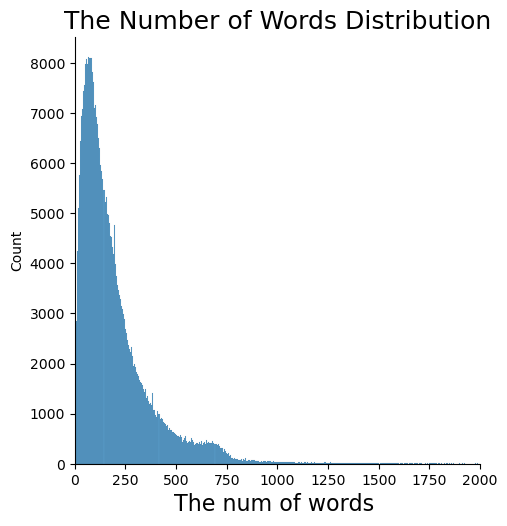

In [128]:
plt.figure(figsize= (8, 8))

sns.displot(df_bert['count'])

plt.xlim(0, 2000)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

In [146]:
df['count'].max()

6314

In [129]:
category_count = df_bert['class_encoded'].value_counts()

categories = df_bert['class_encoded'].unique()

categories

array([ 6,  7, 15, 10,  4,  1,  8, 16, 13,  3,  0,  5,  2, 14, 12,  9, 11,
       17])

In [130]:
category_count

7     84277
6     80436
10    52940
5     29797
15    21778
4     21275
3     18740
0     14852
1     12857
2      9426
16     5713
8      5457
13     4410
12     1739
9      1496
14     1447
11      291
17       14
Name: class_encoded, dtype: int64

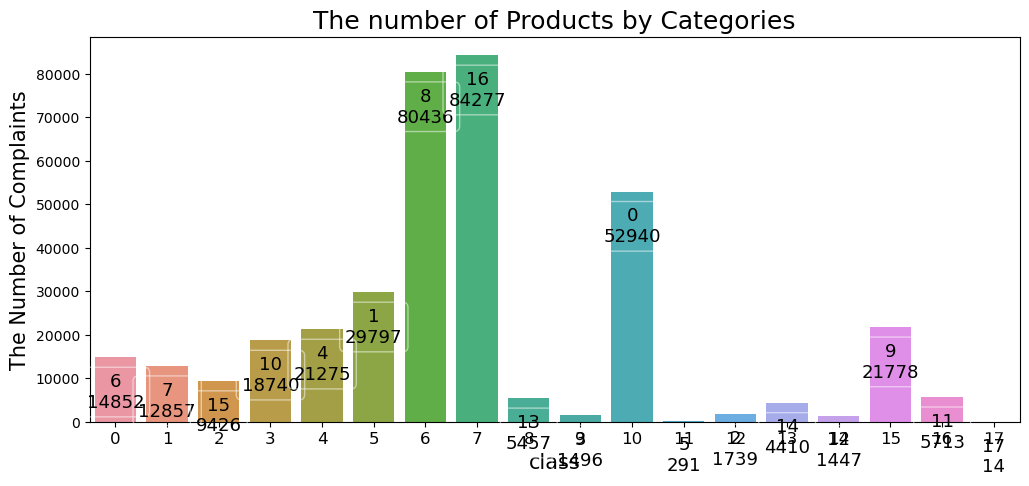

In [131]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'black' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
    
plt.xlabel('class', size = 15)

plt.ylabel('The Number of Complaints', size= 15)

plt.xticks(size = 12)

plt.title("The number of Products by Categories" , size = 18)

plt.show()

In [136]:
data_texts = df_bert['text'].to_list()
data_labels = df_bert['class_encoded'].to_list()

In [145]:
print(len(data_texts))
print(len(data_labels))

366945
366945


In [143]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )


train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.1, random_state = 0)